In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

### Load cleaned data

In [290]:
portfolio = pd.read_pickle('../data/portfolio_cleaned.pkl')
profile = pd.read_pickle('../data/profile_cleaned.pkl')
transcript = pd.read_pickle('../data/transcript_cleaned.pkl')

### Merge profile and transcript datasets

I use an inner join for the transcript and profile datasets as I deleted user_ids with age 118, no gender and no income. These entries won't help us in classifying users later on in the modeling stage. Then I merge the joined dataset with the portfolio dataset to add the offer type. Finally, I drop all the rows, I won't need to define my target variable.

In [291]:
profile_transcript = pd.merge(transcript, profile, how='inner', on='user_id')
merged = pd.merge(profile_transcript, portfolio, how='left', on='offer_id')
merged.drop(['gender', 'age', 'income', 'member_days', 'amount_spent', 'reward_received', 'offer_reward', 'offer_channels', 'offer_difficulty'], axis=1, inplace=True)
merged.head(3)

,user_id,status,test_time,offer_id,offer_duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,5.50,NaN,NaN,NaN


In [292]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272762 entries, 0 to 272761
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         272762 non-null  object 
 1   status          272762 non-null  object 
 2   test_time       272762 non-null  float64
 3   offer_id        148805 non-null  object 
 4   offer_duration  148805 non-null  float64
 5   offer_type      148805 non-null  object 
dtypes: float64(2), object(4)
memory usage: 12.5+ MB


### Examine data and create cross dataset visuals

Let's have a look at the campaign funnel for bogo, discount and informational offers from offer received until offer completed.

In [293]:
campaign_funnel = merged.groupby(['offer_type','status'])['user_id'].count()
campaign_funnel

offer_type     status         
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: user_id, dtype: int64

Text(0.5, 1.0, 'informational')

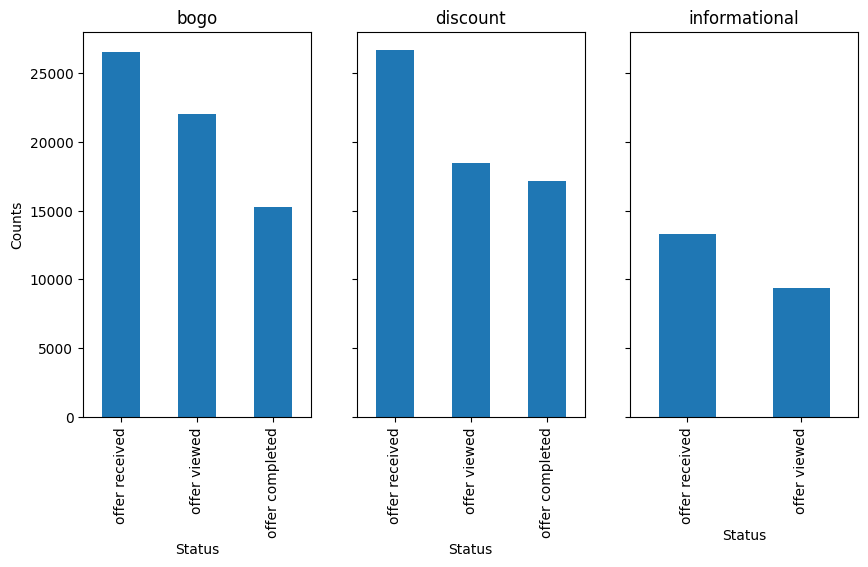

In [294]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True)

ax1 = plt.subplot(131)
bogo = merged[merged['offer_type'] == 'bogo'].status.value_counts()
bogo.plot(kind='bar', figsize=(10,5))
plt.ylabel('Counts')
plt.xlabel('Status')
plt.title('bogo')

ax2 = plt.subplot(132)
discount = merged[merged['offer_type'] == 'discount'].status.value_counts()
discount.plot(kind='bar' , figsize=(10,5))
plt.ylabel('Counts')
plt.xlabel('Status')
plt.title('discount')

ax3 = plt.subplot(133)
informational = merged[merged['offer_type'] == 'informational'].status.value_counts()
informational.plot(kind='bar' , figsize=(10,5))
plt.ylabel('Counts')
plt.xlabel('Status')
plt.title('informational')

Let's have a look at the view and complete rates for the different offer_types:

In [295]:
print('---bogo:---')
print('offer_view_rate:', "{:.1%}".format(campaign_funnel.iloc[2]/campaign_funnel.iloc[1]))
print('offer_complete_rate', "{:.1%}".format(campaign_funnel.iloc[0]/campaign_funnel.iloc[1]))
print('\n')
print('---discount:---')
print('offer_view_rate:', "{:.1%}".format(campaign_funnel.iloc[5]/campaign_funnel.iloc[4]))
print('offer_complete_rate', "{:.1%}".format(campaign_funnel.iloc[3]/campaign_funnel.iloc[4]))
print('\n')
print('---informationl:---')
print('offer_view_rate:', "{:.1%}".format(campaign_funnel.iloc[7]/campaign_funnel.iloc[6]))

---bogo:---
offer_view_rate: 83.1%
offer_complete_rate 57.5%


---discount:---
offer_view_rate: 69.2%
offer_complete_rate 64.5%


---informationl:---
offer_view_rate: 70.4%


### Define Target Variable

As the rates vary between the offer types, I decide to build three different machine learning models. For bogo, discount and informational offers.  
However, the logic to build the target variables for bogo and discount offers is the same.
  
So, let's define our logic whom to send an offer and to whom not:

**bogo** and **discount**:  
offer received > offer viewed > transaction > offer completed -> send offer = 1  
transaction                                                   -> don't send offer = 0  
offer received > transaction                                  -> don't send offer = 0  
offer received > transaction > offer viewed                   -> don't send offer = 0  
offer received > transaction > offer completed > offer viewed -> don't send offer = 0  
offer received > offer viewed                                 -> don't send offer = 0  

**informational**:  
offer received > offer viewed > transaction                   -> send offer = 1  
transaction                                                   -> don't send offer = 0  
offer received > transaction                                  -> don't send offer = 0  
offer received > transaction > offer viewed                   -> don't send offer = 0  

Above, we basically **send** those users an **offer** who **made a transaction within the offer duration and after they viewed the offer**.  
In all other possible combinations, users make a transaction without viewing the offer. Hence, we can assume that they  
would have made a purchase either way. So, we won't send them an offer as this would result in forgone revenues.  

Let's code this logic:

1. We start by filtering the dataset by user_id and test_time.

In [296]:
merged.sort_values(by=['user_id', 'test_time'])
merged.head()

,user_id,status,test_time,offer_id,offer_duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,5.50,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,6.00,NaN,NaN,NaN


2. Forward fill missing cells, so we have the offer id of the last offer in transaction rows

In [297]:
merged.update(merged.groupby(['user_id']).ffill())
merged

,user_id,status,test_time,offer_id,offer_duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,6.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,bogo
...,...,...,...,...,...,...
272757,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,21.00,3f207df678b143eea3cee63160fa8bed,4.0,informational
272758,9fcbff4f8d7241faa4ab8a9d19c8a812,offer received,24.00,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,bogo
272759,9fcbff4f8d7241faa4ab8a9d19c8a812,offer viewed,24.00,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,bogo
272760,3045af4e98794a04a5542d3eac939b1f,offer received,24.00,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,bogo


Of the people who didn't viewed the bogo, discount or informational offer, how many did buy something nonetheless?

In [299]:
# difficulty level overall
print('Difficulty level overall:', merged[(merged['reward_received'].notnull()) & (merged['offer_difficulty'].notnull())]['offer_difficulty'].mean())
# number of users who completed an offer
print('Total unique users:', merged[merged['reward_received'].notnull()]['user_id'].nunique())

# difficulty level bogo
print('Difficulty level bogo:', merged[(merged['reward_received'].notnull()) & (merged['offer_difficulty'].notnull()) & (merged['offer_type'] == 'bogo')]['offer_difficulty'].mean())
#number of users who completed a bogo offer
print('Total unique users who completed a bogo offer:', merged[(merged['reward_received'].notnull()) & (merged['offer_type'] == 'bogo')]['user_id'].nunique())

# difficulty level discount
print('Difficulty level discount:', merged[(merged['reward_received'].notnull()) & (merged['offer_difficulty'].notnull()) & (merged['offer_type'] == 'discount')]['offer_difficulty'].mean())
#number of users who completed a discount offer
print('Total unique users who completed a discount offer:', merged[(merged['reward_received'].notnull()) & (merged['offer_type'] == 'discount')]['user_id'].nunique())

KeyError: 'reward_received'

In [ ]:
# number of users who haven't seen bogo offer
print("Number of users who haven't seen an bogo offer", merged[(merged['offer_type'] == 'bogo') & (merged['status'] == 'offer received')]['user_id'].count() - merged[(merged['offer_type'] == 'bogo') & (merged['status'] == 'offer viewed')]['user_id'].count())
print("Unique ssers who haven't seen an bogo offer", merged[(merged['offer_type'] == 'bogo') & (merged['status'] == 'offer received')]['user_id'].nunique() - merged[(merged['offer_type'] == 'bogo') & (merged['status'] == 'offer viewed')]['user_id'].nunique())



Number of users who haven't seen an bogo offer 4498
Unique ssers who haven't seen an bogo offer 888


### Data Preparation to examine Question 1: